In [322]:
# importando libraries necessárias
from chatminer.chatparsers import WhatsAppParser
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [323]:
# gerando dataframe a partir do arquivo txt
parser = WhatsAppParser('Conversa do WhatsApp com F Le Pé.txt')
parser.parse_file()
df = parser.parsed_messages.get_df()
df.head()

10.12.2023 19:47:23 INFO     
            Depending on the platform, the message format in chat logs might not be
            standardized across devices/versions/localization and might change over
            time. Please report issues including your message format via GitHub.
            
10.12.2023 19:47:23 INFO     Initialized parser.
10.12.2023 19:47:23 INFO     Starting reading raw messages...
10.12.2023 19:47:23 INFO     Inferred date format: day/month/year
10.12.2023 19:47:23 INFO     Finished reading 39998 raw messages.
10.12.2023 19:47:23 INFO     Starting parsing raw messages...
100%|██████████| 39998/39998 [00:01<00:00, 32475.21it/s]
10.12.2023 19:47:24 INFO     Finished parsing raw messages.


,timestamp,author,message,weekday,hour,words,letters
0,2023-12-07 19:20:00,Mateus,vou rodar a análise de texto,Thursday,19,6,28
1,2023-12-07 19:20:00,Mateus,sem mídia,Thursday,19,2,9
2,2023-12-07 19:20:00,Lucas Muniz,com ou sem midia sem midia pega mais texto e c...,Thursday,19,13,59
3,2023-12-07 19:19:00,Lucas Muniz,"ue, sempre foi assim",Thursday,19,4,20
4,2023-12-07 19:18:00,Mateus,é só ir direto nos três pontos e exportat,Thursday,19,9,41


Agora, selecionam-se apenas as mensagens que contenham '@', ou seja, que estão marcando alguém.

In [324]:
lista_booleanos = ['@' in mensagem for mensagem in df['message']]
mensagens_marcadas = df[lista_booleanos]

O código acima deve retonar um dataframe deste tipo:

<img src='imagens readme/mensagens_selecionadas.png' alt='Mensagens Selecionadas'>

Agora, selecionam-se apenas as colunas de autor e mensagem.

In [325]:
mensagens_marcadas = mensagens_marcadas[['author', 'message']]

Faz-se a leitura do arquivo com o nome e número de telefone dos membros do grupo. É importante ressaltar que os nomes precisam ser iguais aos que foram salvos na agenda de quem exportou a conversa.

In [326]:
df_nomes = pd.read_table('nomes_numero2.txt', sep=',', dtype=str)

<img src='imagens readme/nomes_numeros.png'>

Agora, os dataframes df_nomes e mensagens_marcadas são unidos (inner join) pelo número de telefone.

In [327]:
df_de_para = mensagens_marcadas.merge(df_nomes, left_on='author', right_on='nome', how='left')[['numero', 'message']]

<img src='imagens readme/numero_mensagem.png'>

Espera-se um dataframe como se vê acima

In [328]:
# Series com o número de cada membro
series_numeros = df_nomes['numero']

valores = dict() # dicionário vazio
# percorre os números de telefone da series criada acima
for num in series_numeros:
    # seleciona as mensagens cujo remetente é num
    df_temp = df_de_para[df_de_para['numero'] == num]
    # lsita para contagem
    lista_marcacoes_temp = []
    # dicionário para armazenar rementente e quantidade de vezes.
    contagem_nomes = dict()
    # varrendo as mensagens do rementente num
    for mess in df_temp['message']: # de fato, uma mess
        # varrendo novamente num, desta vez para identificar remetentes
        for num2 in series_numeros: 
            # se num2 está na mensagem num marcou num2
            if num2 in mess:
                lista_marcacoes_temp.append(num2)
    # contanco ocorrências
    for nome in lista_marcacoes_temp:
        if nome in contagem_nomes:
            contagem_nomes[nome] += 1
        else:
            contagem_nomes[nome] = 1
    valores[num] = contagem_nomes
    

o dicionário "valores" acima deve ter esta estrutura:

`{'5521XXXXX'} : {'5521YYYYY': 10, 2221ZZZZZZ: 5},
 {'5521YYYYY} : {'5521XXXXX': 5}'}`

Ou seja, 5521XXXXX marcou 5521YYYYY 10 vezes 5521ZZZZZ 5 vezes.

Abaixo, dic_df gerará o dataframe com a estrutura

| de    | para | qtd|
| -------- | ------- |------|
| 5521XXXXX | 5521YYYYY |10|
| 5521XXXXX | 2221ZZZZZZ |5|
| 5521YYYYY | 5521XXXXX |5|


In [329]:

dic_df = {'de': [], 'para': [], 'qtd': []}
for de in valores.keys():
    for chave in valores[de].keys():
        dic_df['de'].append(de)
        dic_df['para'].append(chave)
        dic_df['qtd'].append(valores[de][chave])
de_para_df = pd.DataFrame(dic_df, dtype=str)

In [330]:
vertices_sem_arestas = []
for num in series_numeros:
    if num not in list(pd.concat([de_para_df['de'], de_para_df['para']]).drop_duplicates()):
        vertices_sem_arestas.append(num)

Agora, substituem-se os números pelos nomes

In [331]:
de_para_df['de'] = de_para_df['de'].apply(lambda x: df_nomes.loc[df_nomes['numero'] == x, 'nome'].iloc[0])
de_para_df['para'] = de_para_df['para'].apply(lambda x: df_nomes.loc[df_nomes['numero'] == x, 'nome'].iloc[0])
de_para_df

,de,para,qtd
0,Mateus,Lucas Muniz,17
1,Mateus,Pablo,7
2,Mateus,Inayara,2
3,Mateus,Bolinha,3
4,Mateus,Gabilan,2
5,Mateus,Isabelly,3
6,Mateus,Nathanael,7
7,Mateus,Leila,2
8,Lucas Muniz,Pablo,20
9,Lucas Muniz,Mateus,20


Por fim, gera-se o grafo e fazem-se as operações desejadas

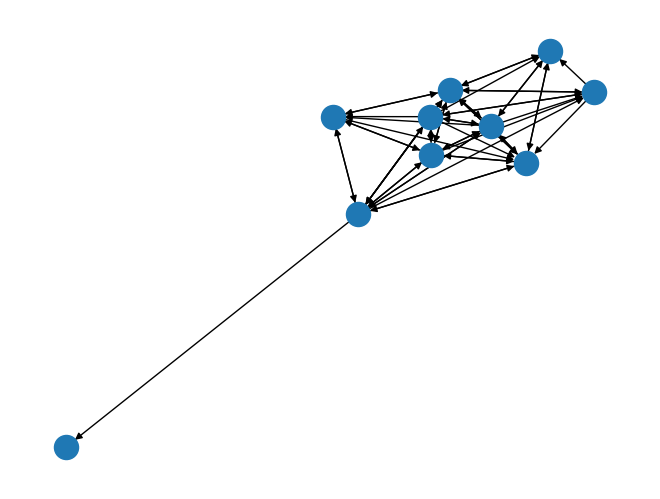

In [332]:
G = nx.from_pandas_edgelist(de_para_df, edge_attr='qtd', create_using=nx.DiGraph,source='de',target='para')
for x in vertices_sem_arestas:
    G.add_node(df_nomes.loc[df_nomes['numero'] == x, 'nome'].iloc[0])
nx.draw(G)

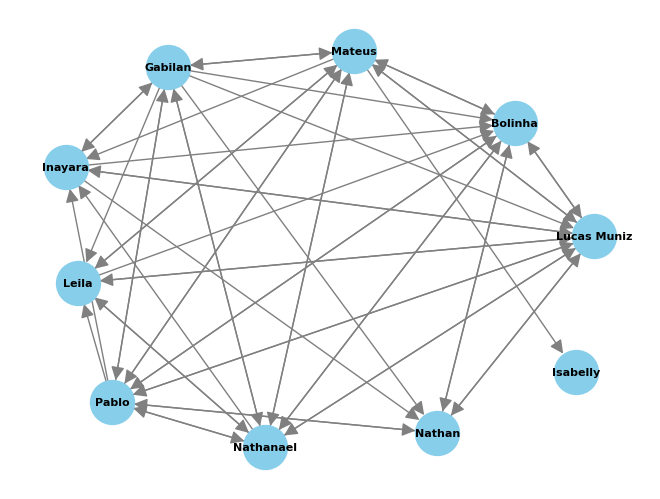

In [333]:
pos = nx.spring_layout(G, seed=42, k=4)

# Desenha o grafo com alpha para tornar ambas as arestas visíveis
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=1000, node_color="skyblue", font_size=8, edge_color="gray", edge_cmap=plt.cm.Blues, arrowsize=20, alpha=1)

# Mostra o gráfico
plt.show()

Infelizmente, não é possível exibir o valor de cada aresta, então o networkx coloca a que veio por último

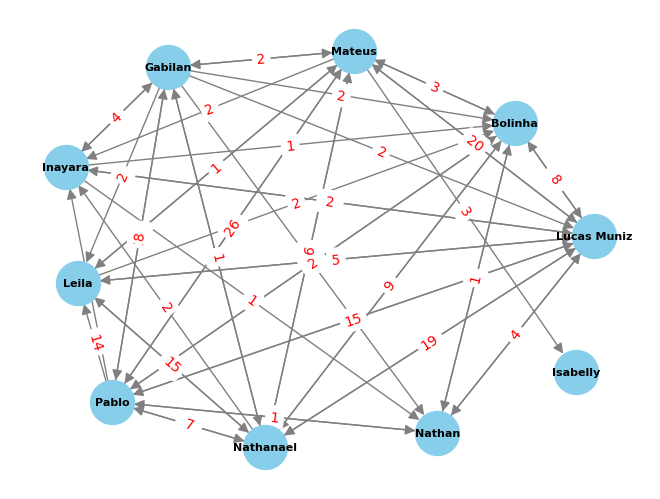

In [334]:
pos = nx.spring_layout(G, seed=42, k=4)

# Desenha o grafo
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=1000, node_color="skyblue", font_size=8, edge_color="gray", width=1, edge_cmap=plt.cm.Blues, arrowsize=15)

# Adiciona rótulos das arestas com os pesos
edge_labels = nx.get_edge_attributes(G, 'qtd')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Mostra o gráfico
plt.show()

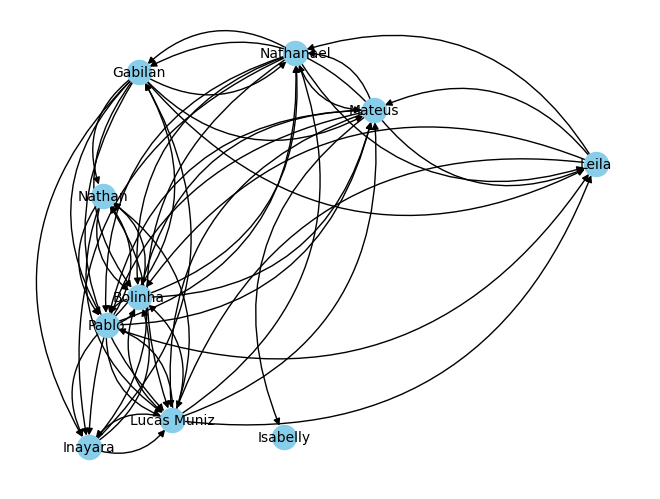

In [335]:
pos = nx.random_layout(G)

# Desenhar o grafo com curvatura nas arestas
nx.draw(G, pos, node_size=300, node_color='skyblue', font_size=10, font_color='black', edge_color = 'white', with_labels=True)

# Adicionar curvatura às arestas
for edge in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=1.0, edge_color='black', connectionstyle="arc3,rad=.4", arrowsize=10)


# Mostrar o gráfico
plt.show()

In [336]:
[x for x in nx.strongly_connected_components(G)]

[{'Isabelly'},
 {'Bolinha',
  'Gabilan',
  'Inayara',
  'Leila',
  'Lucas Muniz',
  'Mateus',
  'Nathan',
  'Nathanael',
  'Pablo'}]

Algumas métricas de vértice

In [337]:
dict(sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True))


{'Lucas Muniz': 1.6666666666666665,
 'Mateus': 1.5555555555555554,
 'Pablo': 1.5555555555555554,
 'Bolinha': 1.4444444444444444,
 'Nathanael': 1.4444444444444444,
 'Gabilan': 1.3333333333333333,
 'Inayara': 1.0,
 'Leila': 1.0,
 'Nathan': 0.8888888888888888,
 'Isabelly': 0.1111111111111111}

In [338]:
dict(sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1], reverse=True))


{'Lucas Muniz': 0.8888888888888888,
 'Bolinha': 0.8888888888888888,
 'Mateus': 0.7111111111111111,
 'Pablo': 0.7111111111111111,
 'Nathanael': 0.7111111111111111,
 'Inayara': 0.6464646464646464,
 'Leila': 0.6464646464646464,
 'Nathan': 0.6464646464646464,
 'Gabilan': 0.5925925925925926,
 'Isabelly': 0.47368421052631576}

In [339]:
dict(sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse=True))

{'Mateus': 0.1412037037037037,
 'Lucas Muniz': 0.07962962962962962,
 'Pablo': 0.0622685185185185,
 'Bolinha': 0.04722222222222222,
 'Nathanael': 0.030092592592592587,
 'Gabilan': 0.02986111111111111,
 'Inayara': 0.009027777777777777,
 'Nathan': 0.003472222222222222,
 'Isabelly': 0.0,
 'Leila': 0.0}

In [340]:
if nx.is_weakly_connected(G) or nx.is_strongly_connected(G):
    dict(sorted(nx.eigenvector_centrality(G).items(), key=lambda item: item[1], reverse=True))

In [341]:
dict(sorted(nx.pagerank(G).items(), key=lambda item: item[1], reverse=True))

{'Lucas Muniz': 0.15021553892759112,
 'Bolinha': 0.1439794364357475,
 'Pablo': 0.12095543751536313,
 'Mateus': 0.1114833833487956,
 'Nathanael': 0.10997446491622147,
 'Nathan': 0.09812941811829626,
 'Inayara': 0.08152726770493589,
 'Leila': 0.08152726770493589,
 'Gabilan': 0.07286892222749483,
 'Isabelly': 0.029338863100618475}